New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration

In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/nyc-taxi-trip-duration"))

# Any results you write to the current directory are saved as output.

['nyc-taxi-trip-duration', 'nytaxi-clean-pairplot', 'data_clean_2']
['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


In [89]:
# !ls ../input/nytaxi-clean-pairplot

In [90]:
!ls ../input/nytaxi-clean-pairplot/pairplot.png

../input/nytaxi-clean-pairplot/pairplot.png


In [103]:
# Import libraries
import datetime
import math

import geopy.distance

import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

## Assess data

Let's first start by loading the training data and inspect it

In [92]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv',
                   parse_dates=['pickup_datetime', 'dropoff_datetime'],
                   dtype={'store_and_fwd_flag':'category'})

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null category
trip_duration         1458644 non-null int64
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 112.7+ MB


In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [9]:
train.shape

(1458644, 11)

### Quality & Tidiness

#### Categorical column (store_and_fwd_flag)
* This column must be converted to a numerical value by using** cat.codes and cast it to int

#### Datetime columns (pickup_datetime)
* datetime columns which are **pickup_datetime** should be split to 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'hour' (We should not need to do this for and **dropoff_datetime** because they are likely to be the same and we already have the tripduration which we try to predict


#### Location columns (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
* To create a train data, create a new column **distance_km** to store a distance value in km computed from (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude) and drop those data that exceed .99 quantile
* Do nothing for the validation data

#### Drop unused columns
* **id** column can be dropped because we do not need it in training
* **pickup_datetime** and **dropoff_datetime** must be dropped after all above are done

## Data Wrangling

Transform the original data to follow our requirements in the Quality & Tidiness section above

In [99]:
def create_datetime_columns(df, column_list):
    
    for col_name in column_list:
        df[col_name+ '_' + 'dayofweek'] = df[col_name].dt.dayofweek
        df[col_name+ '_' + 'dayofyear'] = df[col_name].dt.dayofyear
        df[col_name+ '_' + 'weekofyear'] = df[col_name].dt.weekofyear
        df[col_name+ '_' + 'month'] = df[col_name].dt.month
        df[col_name+ '_' + 'hour'] = df[col_name].dt.hour
        
    return df

In [100]:
def get_distance_km(row):
    coords_1 = (row.pickup_latitude, row.pickup_longitude)
    coords_2 = (row.dropoff_latitude, row.dropoff_longitude)
    
    return geopy.distance.geodesic(coords_1, coords_2).km

In [177]:
def transform_data(df, cleanData=False):
    
    data_clean = df.copy()
    
    #### Categorical column (store_and_fwd_flag)
    # This column must be converted to a numerical value by 
    # using cat.codes and cast it to int
    data_clean['store_and_fwd_flag'] = data_clean['store_and_fwd_flag'].cat.codes

    #### Datetime columns (pickup_datetime)
    # datetime columns which is **pickup_datetime**
    # should be split to 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'hour'
#     data_clean = create_datetime_columns(data_clean, 
#                                          ['pickup_datetime', 'dropoff_datetime'])
    # Only do get additional column for pickup_datetime should be enought because
    # They are typically on the same day
    data_clean = create_datetime_columns(data_clean, 
                                         ['pickup_datetime'])

    #### Location columns (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
    # Create a new column **distance_km** to store a distance value in km computed from (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
    data_clean['distance_km'] = data_clean.apply(lambda row: get_distance_km(row), axis=1)
       
    if cleanData:
        # After doing the exploratory analysis, I found that there are outliers in the dataset
        # (there are trips that have 1k km) that could potentially cause an unexpected behavior
        # Hence, remove those outlier data before proceeding         
        data_clean = data_clean[data_clean.distance_km < data_clean.distance_km.quantile(0.99)]
    
    
    #### Drop unused columns
    # **id** column can be dropped because we do not need it in training
    # **pickup_datetime** and **dropoff_datetime** must be dropped after all above are done

    data_clean = data_clean.drop(['id', 
                                  'pickup_datetime'
                                 ], axis=1)
    
    # Test data does not have dropof_datetime column. Hence, skip it
    if data_clean.columns.contains('dropoff_datetime'):
        data_clean = data_clean.drop(['dropoff_datetime'], axis=1)
    
    return data_clean

In [102]:
%time data_clean = transform_data(train, cleanData=True)
data_clean.reset_index().to_feather('data_clean')

CPU times: user 8min 25s, sys: 1.54 s, total: 8min 27s
Wall time: 8min 27s


ValueError: feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s)

In [35]:
# # # We will use a saved clean data from the previous session here
# data_clean = pd.read_feather('../input/nytaxi-clean-feather/data_clean')

In [111]:
data_clean.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_dayofweek,pickup_datetime_dayofyear,pickup_datetime_weekofyear,pickup_datetime_month,pickup_datetime_hour,distance_km
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,74,11,3,17,1.502172
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,164,23,6,0,1.808660
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,3,1,11,6.379687
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,97,14,4,19,1.483632
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,86,12,3,13,1.187038


In [112]:
# Inspect the output dataframe
data_clean.sample(20)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_dayofweek,pickup_datetime_dayofyear,pickup_datetime_weekofyear,pickup_datetime_month,pickup_datetime_hour,distance_km
1341971,2,1,-73.985840,40.759037,-73.885513,40.773209,0,1715,6,157,22,6,12,8.615708
443665,1,1,-74.015587,40.710854,-73.990318,40.757492,0,1284,6,108,15,4,12,5.601752
1170892,1,1,-73.974434,40.755054,-73.986649,40.739918,0,758,4,134,19,5,11,1.972225
123127,2,3,-74.002357,40.729431,-74.014023,40.714661,0,606,3,154,22,6,7,1.913573
1162543,1,1,-73.984726,40.744671,-73.987740,40.738808,0,441,3,147,21,5,8,0.699086
843186,2,1,-73.980812,40.747738,-73.966927,40.769615,0,1120,2,125,18,5,18,2.697598
1064024,2,1,-73.989006,40.745724,-73.994850,40.721355,0,677,0,25,4,1,2,2.750730
387629,1,1,-73.961281,40.777561,-73.958549,40.769779,0,730,4,106,15,4,12,0.894419
1008546,1,2,-73.954674,40.786987,-73.996170,40.729195,0,2509,3,161,23,6,12,7.312098
991930,1,1,-73.982697,40.758846,-73.963310,40.757893,0,461,0,60,9,2,20,1.640433


In [113]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458498 entries, 0 to 1458643
Data columns (total 14 columns):
vendor_id                     1458498 non-null int64
passenger_count               1458498 non-null int64
pickup_longitude              1458498 non-null float64
pickup_latitude               1458498 non-null float64
dropoff_longitude             1458498 non-null float64
dropoff_latitude              1458498 non-null float64
store_and_fwd_flag            1458498 non-null int8
trip_duration                 1458498 non-null int64
pickup_datetime_dayofweek     1458498 non-null int64
pickup_datetime_dayofyear     1458498 non-null int64
pickup_datetime_weekofyear    1458498 non-null int64
pickup_datetime_month         1458498 non-null int64
pickup_datetime_hour          1458498 non-null int64
distance_km                   1458498 non-null float64
dtypes: float64(5), int64(8), int8(1)
memory usage: 157.2 MB


## Exploratory Data Analysis (EDA)

Before starting the modeling process, let's explore the data a little more to better understand it

### Correlation

In [114]:
corr = data_clean.corr()

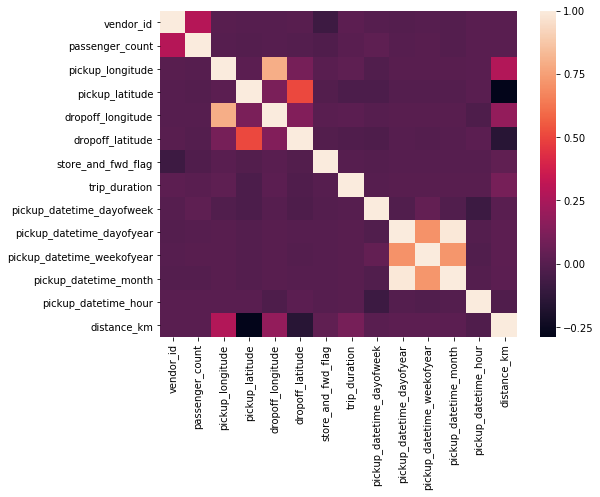

In [115]:
plt.figure(figsize=(8,6))

sns.heatmap(corr);

In [116]:
corr.style.background_gradient(cmap='coolwarm')

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_dayofweek,pickup_datetime_dayofyear,pickup_datetime_weekofyear,pickup_datetime_month,pickup_datetime_hour,distance_km
vendor_id,1,0.287432,0.00779355,0.00219803,0.00127784,0.00459348,-0.0798721,0.0203052,0.00131531,-0.00603271,-0.00161135,-0.00622867,0.00929441,0.00973238
passenger_count,0.287432,1,0.00217651,-0.00469075,-0.000282118,-0.0024486,-0.0218124,0.00844609,0.0251991,-0.00178595,0.00491607,-0.00214708,0.0090957,0.0110786
pickup_longitude,0.00779355,0.00217651,1,0.0147468,0.795555,0.0988882,0.0108767,0.0267659,-0.0164663,0.00438669,0.00670011,0.00460876,0.0102552,0.278241
pickup_latitude,0.00219803,-0.00469075,0.0147468,1,0.112949,0.511342,-0.00883171,-0.0311299,-0.031618,-0.00314931,-0.00623748,-0.00203067,0.0113112,-0.288862
dropoff_longitude,0.00127784,-0.000282118,0.795555,0.112949,1,0.138769,0.00844906,0.0150179,-0.00108787,0.00475698,0.00607644,0.00495375,-0.0227738,0.188405
dropoff_latitude,0.00459348,-0.0024486,0.0988882,0.511342,0.138769,1,-0.0102168,-0.0219227,-0.0226796,-0.0018068,-0.00349961,-0.00083496,0.01401,-0.151307
store_and_fwd_flag,-0.0798721,-0.0218124,0.0108767,-0.00883171,0.00844906,-0.0102168,1,0.00172421,-0.00394883,0.000607831,0.000970493,0.000410996,0.00225132,0.0289472
trip_duration,0.0203052,0.00844609,0.0267659,-0.0311299,0.0150179,-0.0219227,0.00172421,1,-0.000700052,0.00661655,0.00467584,0.00659684,0.00369292,0.102857
pickup_datetime_dayofweek,0.00131531,0.0251991,-0.0164663,-0.031618,-0.00108787,-0.0226796,-0.00394883,-0.000700052,1,-0.0136289,0.0386926,-0.0145589,-0.0842616,0.00865361
pickup_datetime_dayofyear,-0.00603271,-0.00178595,0.00438669,-0.00314931,0.00475698,-0.0018068,0.000607831,0.00661655,-0.0136289,1,0.712486,0.985657,-0.00333703,0.0182989


In [117]:
# # sns_plot = sns.pairplot(df)
# # sns_plot.show()

# # Load a picture of the pairplot generated from the command above instead since
# # it takes a long time (around two hours) to create it
# from IPython.display import Image
# Image("../input/nytaxi-clean-pairplot/pairplot.png")

In [118]:
# Get all column names
data_clean.columns.tolist()

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'pickup_datetime_dayofweek',
 'pickup_datetime_dayofyear',
 'pickup_datetime_weekofyear',
 'pickup_datetime_month',
 'pickup_datetime_hour',
 'distance_km']

### vendor_id

In [119]:
data_clean['vendor_id'].value_counts()

2    780231
1    678267
Name: vendor_id, dtype: int64

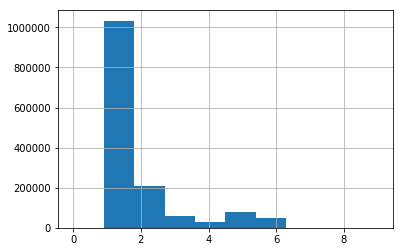

In [120]:
data_clean['passenger_count'].hist();

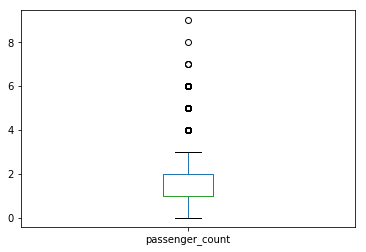

In [121]:
data_clean['passenger_count'].plot.box();

In [122]:
data_clean['passenger_count'].describe()

count    1.458498e+06
mean     1.664535e+00
std      1.314263e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

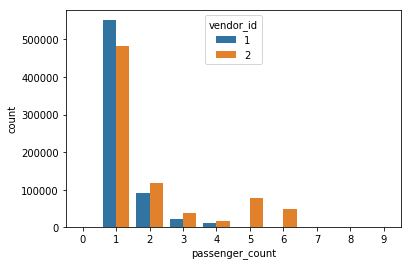

In [123]:
sns.countplot(x="passenger_count", hue="vendor_id", data=data_clean);

### Trip duration

In [130]:
data_clean.distance_km.describe()

count    1.443913e+06
mean     3.241208e+00
std      3.427853e+00
min      0.000000e+00
25%      1.225049e+00
50%      2.071783e+00
75%      3.781366e+00
max      2.079784e+01
Name: distance_km, dtype: float64

In [131]:
data_clean.shape

(1443913, 14)

## Use Default RandomForestRegressor Model

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [133]:
X = data_clean.drop(['trip_duration'], axis=1)
y = data_clean['trip_duration']

In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [136]:
X_train.shape, X_valid.shape

((1155130, 13), (288783, 13))

In [137]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [138]:
m = RandomForestRegressor(n_jobs=-1)

print('[{}] Start'.format(datetime.datetime.now()))

%time m.fit(X_train, y_train)


[2019-05-19 22:16:04.919298] Start


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 4min 36s, sys: 4.02 s, total: 4min 40s
Wall time: 1min 21s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [141]:
print('[{}] Start'.format(datetime.datetime.now()))


%time print_score(m, X_train, X_valid, y_train, y_valid)

[2019-05-19 22:18:48.124978] Start
[2286.016838252315, 4974.859187160323, 0.8188345169569317, -0.12140231459969342]
CPU times: user 40.5 s, sys: 452 ms, total: 41 s
Wall time: 12.6 s


Let's try to predict **trip_duration** of the **train****** data

In [150]:
y_pred_train = m.predict(X_train)

Let's try to predict **trip_duration** of the **validation** data

In [143]:
y_pred = m.predict(X_valid)

Now, let's find of Root Mean Squared Logarithmic Error of the predicted data.
This is an evaluation metrics defined in Kaggle

https://www.kaggle.com/c/nyc-taxi-trip-duration/overview/evaluation

In [147]:
# From https://stackoverflow.com/questions/46202223/root-mean-log-squared-error-issue-with-scitkit-learn-ensemble-gradientboostingre
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

Here is RMSLE of the train data

In [152]:
rmsle(y_train, y_pred_train)

0.2997970488280531

Here is RMSLE of the validation data

In [149]:
rmsle(y_valid, y_pred)

0.5633893038497104

### Just for fun

Let submit this simple model and submit it for the competition to see where we are in the leadership board!

In [161]:
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv',
                   parse_dates=['pickup_datetime'],
                   dtype={'store_and_fwd_flag':'category'})

Inspect the test data first. Notice that the **dropoff_datetime** and **trip_duration** columns are not included in this dataset!

In [162]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [166]:
test.shape

(625134, 9)

We need to transform data before passing it to the model and this can be done by using the **transform_data** function

In [178]:
%time test_clean = transform_data(test)

CPU times: user 3min 33s, sys: 304 ms, total: 3min 34s
Wall time: 3min 34s


Inspect data to ensure that we get all appropriate columns and no rows are removed

In [180]:
test_clean.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_dayofweek,pickup_datetime_dayofyear,pickup_datetime_weekofyear,pickup_datetime_month,pickup_datetime_hour,distance_km
0,1,1,-73.988129,40.732029,-73.990173,40.756680,0,3,182,26,6,23,2.742863
1,1,1,-73.964203,40.679993,-73.959808,40.655403,0,3,182,26,6,23,2.755774
2,1,1,-73.997437,40.737583,-73.986160,40.729523,0,3,182,26,6,23,1.307112
3,2,1,-73.956070,40.771900,-73.986427,40.730469,0,3,182,26,6,23,5.266978
4,1,1,-73.970215,40.761475,-73.961510,40.755890,0,3,182,26,6,23,0.961745


In [181]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 13 columns):
vendor_id                     625134 non-null int64
passenger_count               625134 non-null int64
pickup_longitude              625134 non-null float64
pickup_latitude               625134 non-null float64
dropoff_longitude             625134 non-null float64
dropoff_latitude              625134 non-null float64
store_and_fwd_flag            625134 non-null int8
pickup_datetime_dayofweek     625134 non-null int64
pickup_datetime_dayofyear     625134 non-null int64
pickup_datetime_weekofyear    625134 non-null int64
pickup_datetime_month         625134 non-null int64
pickup_datetime_hour          625134 non-null int64
distance_km                   625134 non-null float64
dtypes: float64(5), int64(7), int8(1)
memory usage: 57.8 MB


In [182]:
test_clean.shape

(625134, 13)

In [183]:
X_sub = test_clean.copy()

In [184]:
y_sub = m.predict(X_sub)

Now, replace data in the **trip_duration** column of a dataframe created from the **sample_submission.csv** with our predicted data, and save it to a csv file for submission

In [185]:
df_sub = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.csv')

In [186]:
df_sub.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [187]:
df_sub['trip_duration'] = y_sub
df_sub.head()

,id,trip_duration
0,id3004672,778.9
1,id3505355,568.0
2,id1217141,444.5
3,id2150126,1141.1
4,id1598245,623.2


In [189]:
df_sub.shape

(625134, 2)

In [188]:
df_sub.to_csv('submission_default_randomforest.csv', index=False)